In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Regex pattern for parsing log entries
log_pattern = re.compile(
    r'(?P<ip>\d+\.\d+\.\d+\.\d+)\s+-\s+(?P<country>[A-Z]+)\s+-\s+\[(?P<timestamp>[^\]]+)\]\s+'
    r'"(?P<method>GET|POST|PUT|DELETE|PATCH|OPTIONS|HEAD)\s+(?P<path>[^"]+)\s+HTTP/[^"]+"\s+'
    r'(?P<status>\d+)\s+\d+\s+"[^"]*"\s+"(?P<user_agent>[^"]+)"\s+(?P<response_time>\d+)'
)

def parse_log_file(file_path):
    records = []

    with open(file_path, 'r') as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                records.append(match.groupdict())

    # Convert to DataFrame
    df = pd.DataFrame(records)

    df['status'] = df['status'].astype(int)
    df['response_time'] = df['response_time'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y:%H:%M:%S')

    return df

file_path = "sample-log.log"
df = parse_log_file(file_path)
print(df.head())


               ip country           timestamp method  \
0   100.34.17.233      NO 2025-07-01 06:00:02    GET   
1   173.80.18.254      NO 2025-07-01 06:00:04   POST   
2       10.3.0.48      SE 2025-07-01 06:00:06    GET   
3   172.56.143.33      US 2025-07-01 06:00:08    GET   
4  208.54.157.184      NO 2025-07-01 06:00:09   POST   

                            path  status  \
0  /news/grammy-nominations-2024     302   
1                              /     200   
2      /podcasts/behind-the-beat     200   
3              /terms-of-service     200   
4                /privacy-policy     200   

                                          user_agent  response_time  
0  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...            269  
1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...            124  
2  Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...            284  
3  Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...            262  
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) App

In [39]:
def general_log_analysis(df, start_time=None, end_time=None, keyword=None):
    """
    Analyze web server logs and return comprehensive statistics.
    
    Parameters:
    df (pandas.DataFrame): Log data with columns [timestamp, ip, path, status, response_time, size, user_agent]
    start_time (str): Start time for filtering (optional)
    end_time (str): End time for filtering (optional)
    keyword (str): Keyword to filter paths (optional)
    
    Returns:
    dict: Dictionary containing analysis results
    """
    # Create a copy to avoid modifying original dataframe
    df = df.copy()
    
    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Time filtering
    if start_time and end_time:
        start_time = pd.to_datetime(start_time)
        end_time = pd.to_datetime(end_time)
        df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

    # Keyword filtering
    if keyword:
        df = df[df['path'].str.contains(keyword, case=False, na=False)]

    summary = {}

    # Basic metrics
    summary['Total Requests'] = len(df)
    summary['Unique IPs'] = df['ip'].nunique()
    
    # Error rate
    summary['Error Rate (%)'] = (
        len(df[df['status'].astype(str).str.startswith(('4', '5'))]) / len(df) * 100
    ) if len(df) > 0 else 0
    
    # Top IPs
    summary['Top IPs'] = df['ip'].value_counts().head(5).to_dict()
    
    # Top Endpoints
    summary['Top Endpoints'] = df['path'].value_counts().head(5).to_dict()
    
    # Status code distribution
    summary['Status Codes'] = df['status'].value_counts().to_dict()
    
    # Requests over time (daily)
    requests_daily = df['timestamp'].dt.floor('D').value_counts().sort_index()
    summary['Requests Over Time (Daily)'] = requests_daily.to_dict()
    
    # Peak hours
    peak_hours = df['timestamp'].dt.hour.value_counts().sort_index()
    summary['Peak Hours'] = peak_hours.head(5).to_dict()
    
    # User agent analysis (if available)
    if 'user_agent' in df.columns:
        summary['Top User Agents'] = df['user_agent'].value_counts().head(5).to_dict()
    
    # Bandwidth usage (if size column exists)
    if 'size' in df.columns:
        summary['Total Bandwidth (MB)'] = round(df['size'].sum() / (1024 * 1024), 2)
    
    # Slowest endpoints (if response_time exists)
    if 'response_time' in df.columns:
        slowest = (
            df.groupby('path')['response_time']
            .mean()
            .sort_values(ascending=False)
            .head(5)
            .round(2)
            .to_dict()
        )
        summary['Slowest Endpoints (avg ms)'] = slowest

    return summary

def pretty_print_analysis(summary, timezone='UTC'):
    """
    Pretty print the log analysis results in a formatted manner.
    
    Parameters:
    summary (dict): Analysis results from general_log_analysis
    timezone (str): Timezone for displaying timestamps
    """
    def print_section(title):
        print(f"\n{'=' * 50}\n{title}\n{'=' * 50}")
    
    def format_timestamp(ts):
        return pd.Timestamp(ts).tz_localize('UTC').tz_convert(timezone).strftime('%Y-%m-%d %H:%M:%S %Z')
    
    print_section("Log Analysis Summary")
    
    # Basic Metrics
    print(f"Total Requests: {summary['Total Requests']:,}")
    print(f"Unique IPs: {summary['Unique IPs']:,}")
    print(f"Error Rate: {summary['Error Rate (%)']:.2f}%")
    
    # Top IPs
    print_section("Top 5 Source IPs")
    for ip, count in summary['Top IPs'].items():
        print(f"{ip}: {count:,} requests")
    
    # Top Endpoints
    print_section("Top 5 Endpoints")
    for path, count in summary['Top Endpoints'].items():
        print(f"{path}: {count:,} requests")
    
    # Status Codes
    print_section("Status Code Distribution")
    for status, count in summary['Status Codes'].items():
        print(f"Status {status}: {count:,} requests")
    
    # Requests Over Time
    print_section("Requests Over Time (Daily)")
    for date, count in summary['Requests Over Time (Daily)'].items():
        formatted_date = format_timestamp(date)
        print(f"{formatted_date.split()[0]}: {count:,} requests")
    
    # Peak Hours
    print_section("Peak Hours")
    for hour, count in summary['Peak Hours'].items():
        print(f"Hour {hour:02d}:00: {count:,} requests")
    
    # User Agents
    if 'Top User Agents' in summary:
        print_section("Top 5 User Agents")
        for ua, count in summary['Top User Agents'].items():
            print(f"{ua[:50]}...: {count:,} requests")
    
    # Bandwidth
    if 'Total Bandwidth (MB)' in summary:
        print_section("Bandwidth Usage")
        print(f"Total: {summary['Total Bandwidth (MB)']:.2f} MB")
    
    # Slowest Endpoints
    if 'Slowest Endpoints (avg ms)' in summary:
        print_section("Slowest Endpoints (Average Response Time)")
        for path, time in summary['Slowest Endpoints (avg ms)'].items():
            print(f"{path}: {time:.2f} ms")


In [40]:
pretty_print_analysis(general_log_analysis(df))


Log Analysis Summary
Total Requests: 432,096
Unique IPs: 40,887
Error Rate: 12.72%

Top 5 Source IPs
45.133.1.2: 5,400 requests
45.133.1.1: 5,400 requests
35.185.0.156: 3,600 requests
194.168.1.2: 1,859 requests
194.168.1.6: 1,855 requests

Top 5 Endpoints
/episodes/ep-42-synthesizer-history: 15,876 requests
/contact: 15,839 requests
/about: 15,729 requests
/artists/emerging-indie-artists: 15,685 requests
/podcasts/music-producer-interviews: 15,685 requests

Status Code Distribution
Status 200: 354,706 requests
Status 404: 38,061 requests
Status 301: 11,169 requests
Status 302: 7,511 requests
Status 401: 5,338 requests
Status 500: 5,233 requests
Status 304: 3,765 requests
Status 429: 1,821 requests
Status 504: 1,459 requests
Status 503: 1,430 requests
Status 403: 1,176 requests
Status 423: 427 requests

Requests Over Time (Daily)
2025-07-01: 99,202 requests
2025-07-02: 113,264 requests
2025-07-03: 113,351 requests
2025-07-04: 106,279 requests

Peak Hours
Hour 05:00: 3,600 requests
Hou

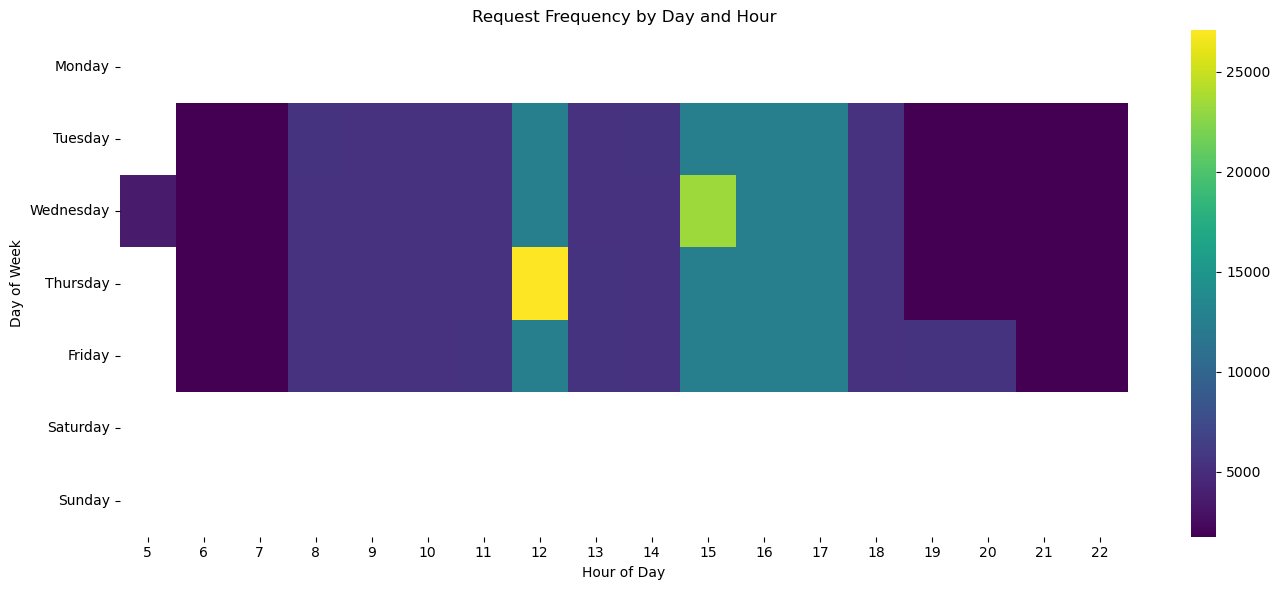

In [41]:
# numbers are great but data visualisation is better

# create a heat map of day and hour to see taffic
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

# Create a pivot table
heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Request Frequency by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


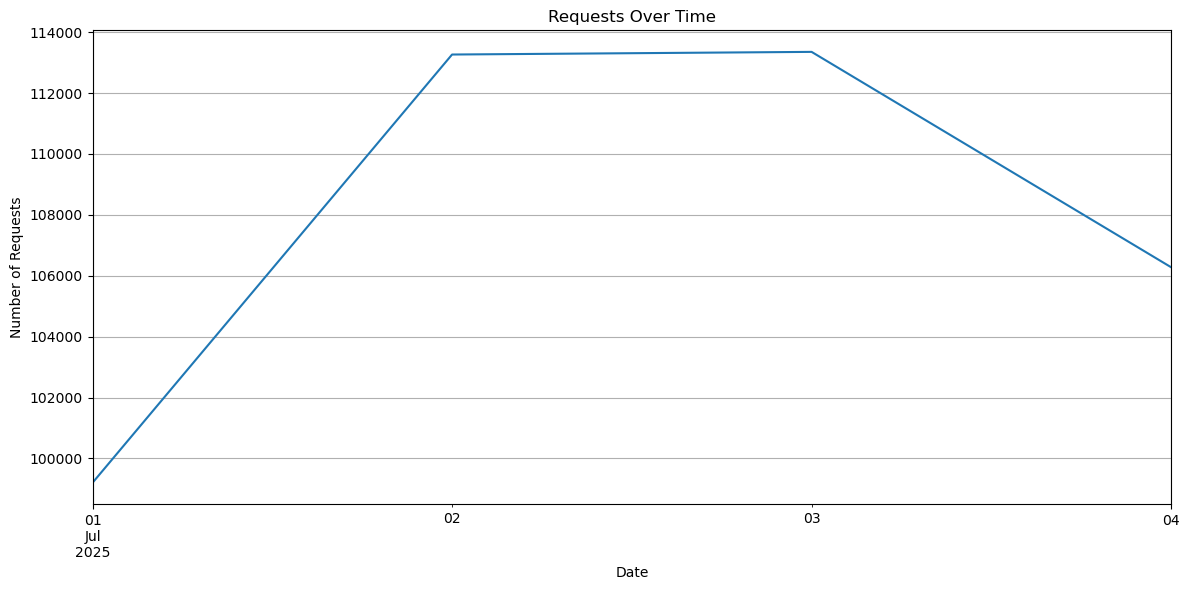

In [42]:
# line graph to show requests over time

requests_over_time = df['timestamp'].dt.floor('D').value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
requests_over_time.plot()
plt.title('Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.grid(True)
plt.tight_layout()
plt.show()

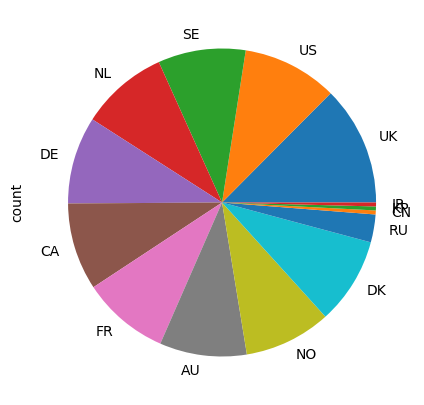

In [103]:
country_count = df['country'].value_counts()

plot = country_count.plot.pie(y='country', figsize=(5, 5))

In [66]:
russian_bot = df[df['ip'] == '45.133.1.1']
print(russian_bot)
print(russian_bot['user_agent'].value_counts())

                ip country           timestamp   method  \
151435  45.133.1.1      RU 2025-07-02 15:00:00  OPTIONS   
151436  45.133.1.1      RU 2025-07-02 15:00:00  OPTIONS   
151437  45.133.1.1      RU 2025-07-02 15:00:00  OPTIONS   
151448  45.133.1.1      RU 2025-07-02 15:00:02      PUT   
151449  45.133.1.1      RU 2025-07-02 15:00:02      GET   
...            ...     ...                 ...      ...   
174782  45.133.1.1      RU 2025-07-02 15:59:56     POST   
174783  45.133.1.1      RU 2025-07-02 15:59:56     HEAD   
174795  45.133.1.1      RU 2025-07-02 15:59:58    PATCH   
174796  45.133.1.1      RU 2025-07-02 15:59:58      PUT   
174797  45.133.1.1      RU 2025-07-02 15:59:58      GET   

                               path  status  \
151435                /api/v1/users     200   
151436            /api/v2/users/../     404   
151437         /api/v3/users/../../     404   
151448    /api/v2/users/profile/dev     404   
151449  /api/v3/users/profile/debug     404   
...      

In [116]:
bot_keywords = [
    # Generic bot identifiers
    'bot', 'spider', 'crawler', 'slurp', 'feedfetcher', 'nutch',
    # Common scraping tools and libraries
    'curl', 'wget', 'scrapy', 'httpclient', 'aiohttp', 'libwww', 'node-fetch', 'httpx', 'axios',
    # Testing and security tools
    'burp suite', 'sqlmap', 'nikto', 'postman',
    # Automation and headless browsers
    'phantomjs', 'selenium', 'headless',
    # Programming languages (used cautiously, as they may appear in legitimate UAs)
    'python-requests', 'ruby', 'java/http', 'go-http'
]

# Compile regex pattern for better performance, using word boundaries to avoid false positives
pattern = r'\b(' + '|'.join(map(re.escape, bot_keywords)) + r')\b'

suspicious_ips = df[df['user_agent'].str.contains(pattern, case=False, na=False, regex=True)]['ip'].unique()

# Step 2: Flag all logs from those IPs
user_agent_bots = df[df['ip'].isin(suspicious_ips)]
# Output results
print(f"Detected {len(user_agent_bots)} potential requests from bots")
print(f"Percentage of requests {len(user_agent_bots)/len(df)*100}%")

/tmp/ipykernel_88923/2811852096.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  suspicious_ips = df[df['user_agent'].str.contains(pattern, case=False, na=False, regex=True)]['ip'].unique()


Detected 21600 potential requests from bots
Percentage of requests 4.9988891357476115%


In [109]:
request_threshold = max(100, df.groupby('ip').size().quantile(0.95))  # Top 1% or 100
request_counts = df.groupby('ip').size().reset_index(name='request_count')
high_request_ips = request_counts[request_counts['request_count'] > request_threshold]['ip']
high_request_logs = df[df['ip'].isin(high_request_ips)]

print(len(high_request_logs))

36000


In [118]:
df['minute'] = df['timestamp'].dt.floor('min')
request_rate = df.groupby(['ip', 'minute']).size().reset_index(name='requests_per_minute')
high_rate_ips = request_rate[request_rate['requests_per_minute'] > 25]['ip']  # Adjust threshold
high_rate_logs = df[df['ip'].isin(high_rate_ips)]

print(f"Total high rate logs {len(high_rate_logs)}")
print(f"Percentage of total requests: {len(high_rate_logs)/len(df)*100}%")

Total high rate logs 28800
Percentage of total requests: 6.665185514330149%


In [111]:
total_suspicious_logs =  pd.concat([
    user_agent_bots,
    high_rate_logs,
    high_request_logs
]).drop_duplicates(subset=['ip', 'timestamp', 'user_agent', 'path', 'status', 'response_time'])

print(f"Total requests that are suspicious: {len(total_suspicious_logs)/len(df) * 100}%")

Total requests that are suspicious: 8.331481892912686%



Log Analysis Summary
Total Requests: 36,000
Unique IPs: 16
Error Rate: 58.18%

Top 5 Source IPs
45.133.1.1: 5,400 requests
45.133.1.2: 5,400 requests
35.185.0.156: 3,600 requests
194.168.1.2: 1,859 requests
194.168.1.6: 1,855 requests

Top 5 Endpoints
/search: 1,743 requests
/privacy-policy: 563 requests
/about: 542 requests
/contact: 540 requests
/articles/the-evolution-of-jazz: 540 requests

Status Code Distribution
Status 200: 15,054 requests
Status 404: 7,826 requests
Status 401: 5,338 requests
Status 429: 1,821 requests
Status 500: 1,469 requests
Status 504: 1,459 requests
Status 503: 1,430 requests
Status 403: 1,176 requests
Status 423: 427 requests

Requests Over Time (Daily)
2025-07-02: 14,400 requests
2025-07-03: 14,400 requests
2025-07-04: 7,200 requests

Peak Hours
Hour 05:00: 3,600 requests
Hour 12:00: 14,400 requests
Hour 15:00: 10,800 requests
Hour 19:00: 3,600 requests
Hour 20:00: 3,600 requests

Top 5 User Agents
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWeb...: 5

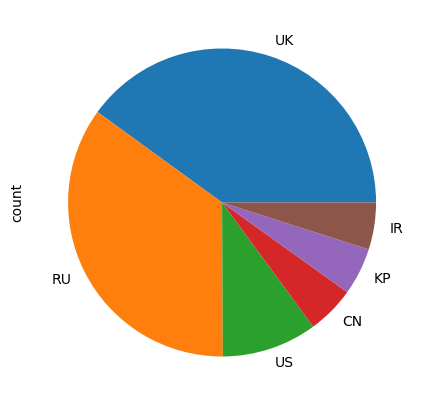

In [117]:
pretty_print_analysis(general_log_analysis(total_suspicious_logs))

sus_country_count = total_suspicious_logs['country'].value_counts()

plot = sus_country_count.plot.pie(y='country', figsize=(5, 5))

In [90]:
prev_logs = 60
df.iloc[int(error_logs.iloc[0][7])-prev_logs:int(error_logs.iloc[0][7])] # looks at the records before the server error (this gets me nowhere)

/tmp/ipykernel_88923/783660280.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[int(error_logs.iloc[0][7])-prev_logs:int(error_logs.iloc[0][7])] # looks at the records before the server error (this gets me nowhere)


,ip,country,timestamp,method,path,status,user_agent,response_time,day_of_week,hour,minute
4,208.54.157.184,NO,2025-07-01 06:00:09,POST,/privacy-policy,200,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,118,Tuesday,6,2025-07-01 06:00:00
5,96.114.162.7,SE,2025-07-01 06:00:15,GET,/images/banner.jpg,200,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,374,Tuesday,6,2025-07-01 06:00:00
6,107.78.231.35,FR,2025-07-01 06:00:16,GET,/subscribe-premium,200,Mozilla/5.0 (Linux; Android 14; SM-G998B) Appl...,262,Tuesday,6,2025-07-01 06:00:00
7,174.54.112.5,DK,2025-07-01 06:00:17,GET,/podcasts/music-producer-interviews,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,164,Tuesday,6,2025-07-01 06:00:00
8,192.168.3.81,FR,2025-07-01 06:00:19,POST,/api/episodes,404,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,606,Tuesday,6,2025-07-01 06:00:00
9,99.224.121.154,US,2025-07-01 06:00:22,GET,/privacy-policy,200,Mozilla/5.0 (Linux; Android 14; SM-G998B) Appl...,248,Tuesday,6,2025-07-01 06:00:00
10,172.21.0.92,DE,2025-07-01 06:00:23,GET,/api/episodes,200,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,364,Tuesday,6,2025-07-01 06:00:00
11,100.34.131.87,DK,2025-07-01 06:00:25,GET,/contact,200,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,204,Tuesday,6,2025-07-01 06:00:00
12,68.1.252.104,SE,2025-07-01 06:00:27,POST,/api/v1/auth/login?username=bob%40company.com,200,Mozilla/5.0 (Linux; Android 14; SM-G998B) Appl...,523,Tuesday,6,2025-07-01 06:00:00
13,174.50.109.73,DK,2025-07-01 06:00:28,GET,/reviews/album-review-midnight-echoes,200,Mozilla/5.0 (iPad; CPU OS 17_2_1 like Mac OS X...,347,Tuesday,6,2025-07-01 06:00:00
